In [2]:
# Load the video data 
import numpy as np
import skvideo.io
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.widgets import Slider, Button
from tqdm import tqdm
from queue import Queue
import scipy.optimize as opt
import pickle
import pandas as pd
import seaborn as sns
import xarray as xr
%matplotlib inline

In [3]:
filename = "sample.mp4" 
frames_to_load = 7273 # this is necessary because it seems to crash at the end of the video 

moviedata = skvideo.io.vread(filename, num_frames=frames_to_load)

print(moviedata.shape)

(7273, 384, 384, 3)


In [4]:
# So all color channels contain the same data. I think we can safely drop all the extra channels. I also think we can crop a bit, maybe 50 pixels off each side.
crop = 50
test_frames = 100

# use this version for quicky figures:
raw = moviedata[:test_frames, crop:-crop, crop:-crop, 0]
# and this version for the full movie: 
# raw = moviedata[:, crop:-crop, crop:-crop, 0]

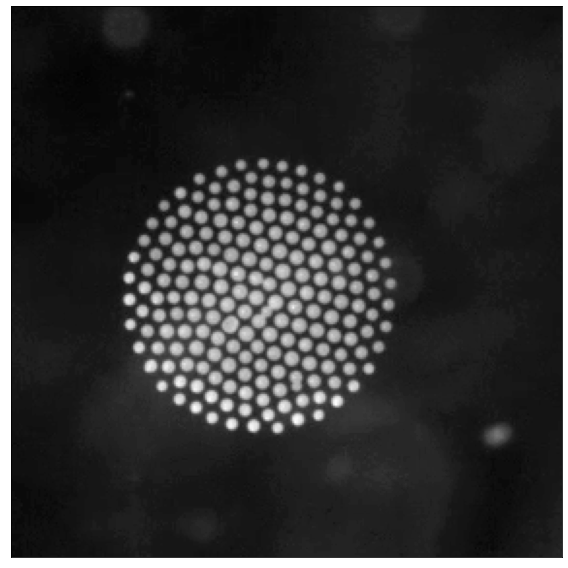

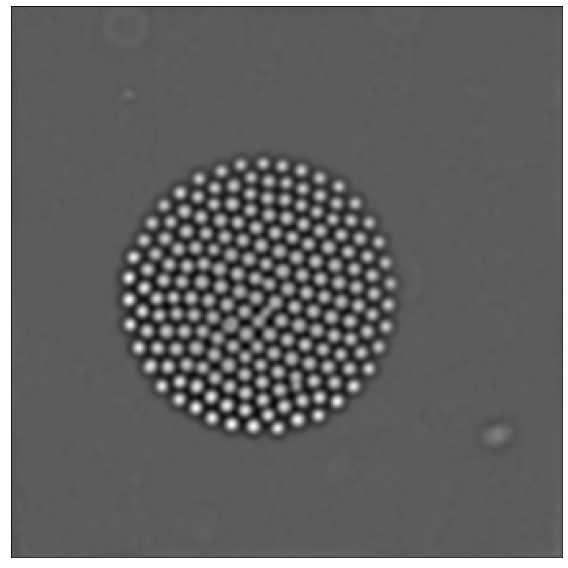

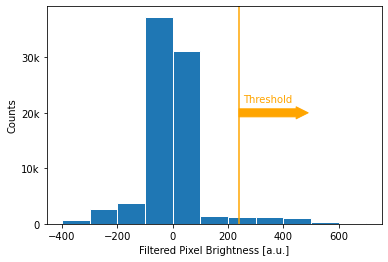

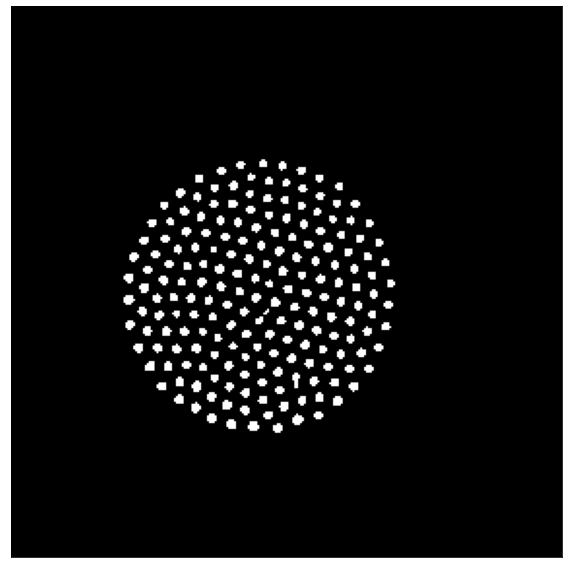

In [5]:

filter_scale = 3.25
threshold = 240


[T, X, Y] = raw.shape
x = np.arange(-X/2, X/2)
y = np.arange(-Y/2, Y/2)
#print(np.size(x),np.size(y))
x2d, y2d = np.meshgrid(y, x)
radius = np.sqrt(x2d**2 + y2d**2)
real_space_filter = np.exp(-2 * (radius / filter_scale)**2) * (1 - 2 * (radius / filter_scale)**4)

def implot(name):
    f = plt.gcf()
    f.set_figwidth(8)
    f.set_figheight(8)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.savefig(name)
    plt.show()


plt.figure()
plt.imshow(raw[0], "gray")
implot("raw.pdf")


fft_data = np.fft.fft2(raw, axes=[1, 2])
fourier_filter = np.fft.fft2(np.fft.fftshift(real_space_filter))
filtered = np.real(np.fft.ifft2(fft_data*fourier_filter))
plt.figure()
plt.imshow(filtered[0], "gray")
implot("filtered.pdf")

plt.figure()
plt.hist(np.ravel(filtered[0]), bins=np.arange(-400, 701, 100), ec="white")
yl = plt.ylim()
plt.plot([threshold, threshold], [0, 1e7], color="orange")
arrowprops = {"width": 8, "color": "orange", "headwidth": 12}
plt.annotate("", [threshold+250, 2e4], xytext=[threshold, 2e4], color="orange", arrowprops=arrowprops)
plt.annotate("Threshold", [threshold+15, 2.2e4], color="orange")
plt.ylim(yl)
plt.yticks([0, 1e4, 2e4, 3e4], labels=["0", "10k", "20k", "30k"])
plt.xlabel("Filtered Pixel Brightness [a.u.]")
plt.ylabel("Counts")
plt.savefig("threshold.pdf")
plt.show()

thresh = np.copy(filtered)
thresh[thresh < threshold] = 0
thresh[thresh > 0] = 1
binary = np.asarray(thresh, dtype=bool)
plt.figure()
plt.imshow(binary[0], "gray")
implot("binary.pdf")

In [6]:
# do smarter particle assignment
# from https://en.wikipedia.org/wiki/Connected-component_labeling

def check_adjacent(i, j, data, status, q):
    # process adjacent pixels and add them to the queue if need be 
    if not status[i, j]:
        if data[i, j]:
            q.put([i, j])
        else: 
            status[i, j] = True

def find_connected_components(data):
    [X, Y] = data.shape
    curr = 0
    labels = np.zeros_like(data, dtype=int) - 1
    status = np.zeros_like(data, dtype=bool)
    q1 = Queue()
    q2 = Queue()
    for i in range(X):
        for j in range(Y):

            # skip this pixel if we already got it
            if status[i, j]:
                continue

            # if this pixel is false, flag it as processed and continue
            if not data[i, j]:
                status[i, j] = True
                continue
        
            # check adjacent pixels and add them to the queue if needed 
            check_adjacent(i, j+1, data, status, q1)
            check_adjacent(i, j-1, data, status, q1)
            check_adjacent(i+1, j, data, status, q1)
            check_adjacent(i-1, j, data, status, q1)
            labels[i, j] = curr
            status[i, j] = True
            # process the queue
            while not q1.empty():
                [a, b] = q1.get()
                check_adjacent(a, b+1, data, status, q2)
                check_adjacent(a, b-1, data, status, q2)
                check_adjacent(a+1, b, data, status, q2)
                check_adjacent(a-1, b, data, status, q2)
                labels[a, b] = curr
                status[a, b] = True
                while not q2.empty():
                    q1.put(q2.get())
            curr += 1

    return labels, curr-1

particle = np.zeros_like(raw, dtype=int)
n_particles = np.zeros(T, dtype=int)

for t in tqdm(range(T)):
    l, n = find_connected_components(binary[t])
    particle[t] = l
    n_particles[t] = n

100%|██████████| 100/100 [00:06<00:00, 16.27it/s]


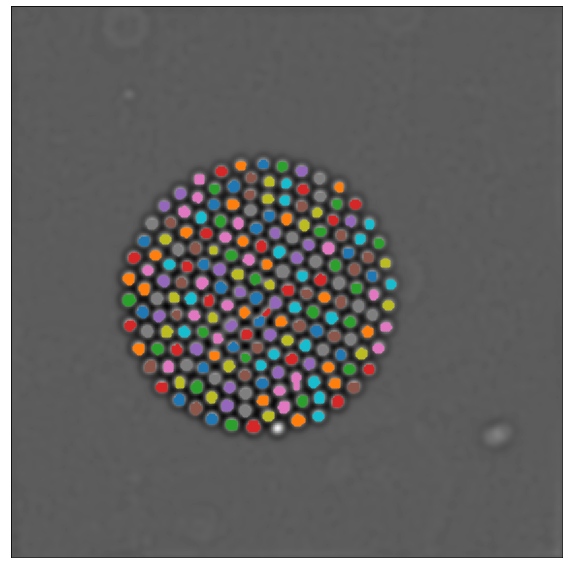

In [7]:
plt.figure()
plt.imshow(filtered[0], "gray")
for i in range(n_particles[0]):
    p = np.argwhere(particle[0]==i)
    plt.plot(p[:, 1], p[:, 0], ".")
implot("assigned.pdf")

In [16]:
def com(xy, d):
    return np.average(xy, axis=1, weights=d[xy[1, :], xy[0, :]])

P = max(n_particles)
centers = np.empty((T, 2, P))
centers[:] = np.nan
for t in tqdm(range(T)):
    for p in range(n_particles[t]):
        xy = np.transpose(np.argwhere(particle[t] == p))
        centers[t, :, p] = np.average(
            xy, axis=1, weights=filtered[t, xy[0], xy[1]])


100%|██████████| 100/100 [00:04<00:00, 24.10it/s]


In [9]:
# for the time being, just keep track of the velocities and their corresponding positions.
disps = np.empty((T-1, 2, P))
disps[:] = np.nan
nextinds = np.empty((T-1, P)) 
nextinds[:] = np.nan
for t in tqdm(range(T-1)):
    for p in range(n_particles[t]):
        minval = np.inf
        for q in range(n_particles[t+1]):
            disp = centers[t, :, p] - centers[t+1, :, q]
            d = sum(disp**2)
            if (d < minval) and (d < 1):
                minval = d
                disps[t, :, p] = disp
                nextinds[t, p] = q
        
    vals, counts = np.unique(nextinds[t], return_counts=True)
    for q in np.argwhere(counts > 1):
        minval = np.inf
        source = np.nan
        wrong = np.argwhere(nextinds[t] == vals[q])
        for l in wrong:
            d = sum(sum(disps[t, :, l]**2))
            if d < minval:
                minval = d
                source = l
        for l in wrong:
            if l == source:
                continue
            disps[t, :, l] = np.nan
            nextinds[t, l] = np.nan
    


100%|██████████| 99/99 [00:04<00:00, 21.75it/s]


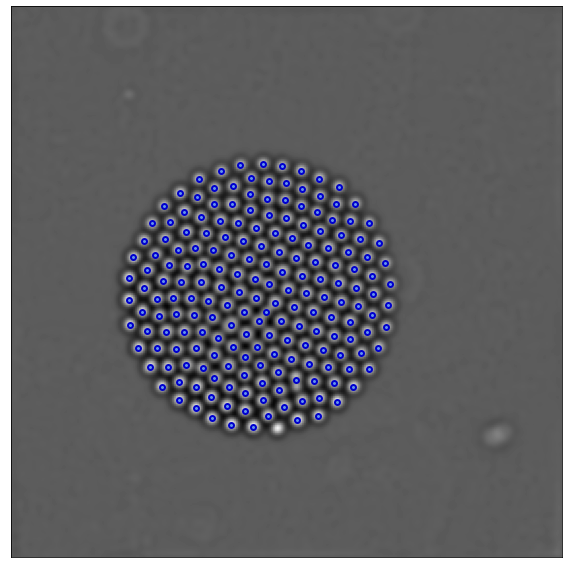

In [26]:
plt.figure()
plt.imshow(filtered[0], "gray")
plt.plot(centers[0, 1], centers[0, 0], ".", color="cornflowerblue", markersize=10,
         markeredgecolor="mediumblue", markeredgewidth=2)
implot("centers.pdf")


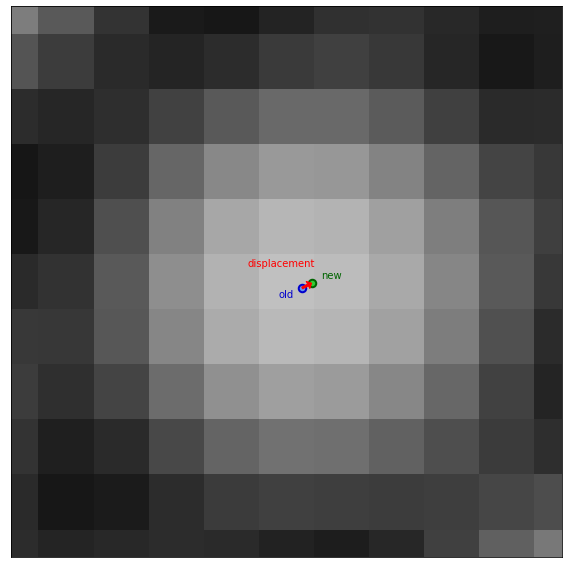

In [51]:
plt.figure()
plt.imshow(filtered[1], "gray")
plt.plot(centers[0, 1], centers[0, 0], ".", color="cornflowerblue", markersize=15,
         markeredgecolor="mediumblue", markeredgewidth=2)
plt.plot(centers[1, 1], centers[1, 0], ".", color="limegreen", markersize=15,
         markeredgecolor="darkgreen", markeredgewidth=2)


plt.xlim([150, 160])
plt.ylim([152, 162])
for p in range(n_particles[0]):
    arrowprops = {"width": 2, "color": "red", "headwidth": 8, "headlength": 4}
    plt.annotate("",
                 [centers[0, 1, p]-disps[0, 1, p], centers[0, 0, p]-disps[0, 0, p]],
                 xytext=[centers[0, 1, p], centers[0, 0, p]], 
                 arrowprops=arrowprops)
    plt.annotate("new", [centers[0, 1, p]-2*disps[0, 1, p], centers[0, 0, p]-2*disps[0, 0, p]],color="darkgreen")
    plt.annotate("old", [centers[0, 1, p]+2.5*disps[0, 1, p], centers[0, 0, p]+2*disps[0, 0, p]],color="mediumblue")
    plt.annotate("displacement", [centers[0, 1, p]-1, centers[0, 0, p]+0.4],color="red")

implot("disps.pdf")


In [65]:
kes = np.sum(disps**2, axis=1)


In [ ]:
# trackingresults = {
#     "raw": raw,
#     "filtered": filtered,
#     "binary": binary,
#     "particle": particle,
#     "n_particles": n_particles,
#     "centers": centers,
#     "disps": disps,
#     "nextinds": nextinds,
#     "kes": kes
# }

# pickle.dump(trackingresults, open("trackingresults.p", "wb"))


In [56]:
trackingresults = pickle.load(open("trackingresults.p", "rb"))
raw = trackingresults["raw"]
filtered = trackingresults["filtered"]
binary = trackingresults["binary"]
particle = trackingresults["particle"]
n_particles = trackingresults["n_particles"]
centers = trackingresults["centers"]
disps = trackingresults["disps"]
nextinds = trackingresults["nextinds"]
kes = trackingresults["kes"]

[T, X, Y] = raw.shape
[_, P] = nextinds.shape

In [57]:
nextinds = np.array(nextinds, dtype=int)
startinds = np.empty((T, P), dtype=int)
startinds[:] = -1
startinds[0] = np.arange(P)
for t in range(T-1):
    for p in range(P):
        # if not (np.isnan(nextinds[t, p]) or np.isnan(startinds[t, p])):
        startinds[t+1, nextinds[t, p]] = startinds[t, p]

for t in range(T):
    centers[t, 0] = centers[t, 0] - np.nanmean(centers[t, 0])
    centers[t, 1] = centers[t, 1] - np.nanmean(centers[t, 1])

totaldisps = np.empty((T, P, 2))
for t in range(T):
    for p in range(P):
        if startinds[t, p] >= 0:
            totaldisps[t, p] = centers[t, :, startinds[t, p]] - centers[t, :, startinds[0, p]]
        else:
            totaldisps[t, p] = np.nan 

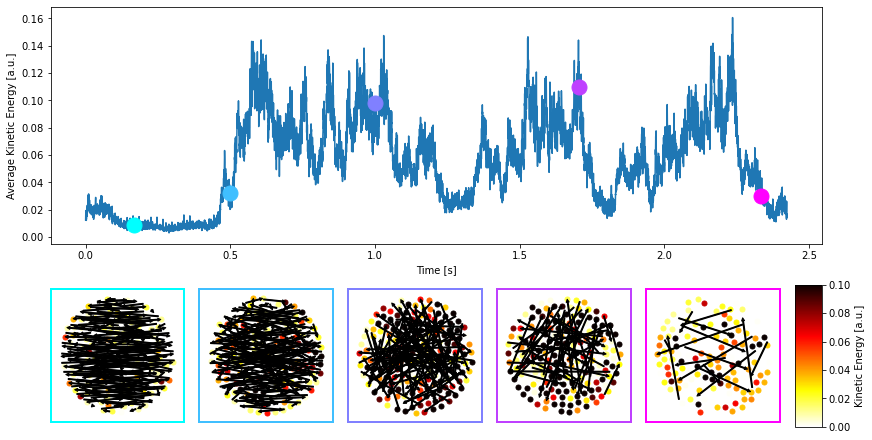

In [64]:
timeax = np.arange(T-1)/3000

subfigtimes = [500, 1500, 3000, 5120, 7000]
# subfigtimes = [0, 10, 200, 1000, 6000]
subfigcolors = np.linspace(0, 1, 5)
subfigcolors = np.transpose(np.array([subfigcolors, 1-subfigcolors, 1 + 0*subfigcolors]))

mval = 0.1
arrowgain = 1
xw = yw = 80
hot = mpl.cm.get_cmap('hot_r')
def cmap(c):
    return hot(c / mval)


fig = plt.figure(figsize=(12, 6), constrained_layout=True)
widths = [1, 1, 1, 1, 1, 0.2]
heights = [1, 0.6]
spec = fig.add_gridspec(ncols=6, nrows=2, width_ratios=widths, height_ratios=heights)
axA = fig.add_subplot(spec[0, :])
ax1 = fig.add_subplot(spec[1, 0])
ax2 = fig.add_subplot(spec[1, 1])
ax3 = fig.add_subplot(spec[1, 2])
ax4 = fig.add_subplot(spec[1, 3])
ax5 = fig.add_subplot(spec[1, 4])
axC = fig.add_subplot(spec[1, 5])

norm = mpl.colors.Normalize(vmin=0, vmax=mval)     
mpl.colorbar.ColorbarBase(
    axC, cmap=hot, orientation='vertical', label="Kinetic Energy [a.u.]",
    norm=norm)

subaxs = [ax1, ax2, ax3, ax4, ax5]

for a, ax in enumerate(subaxs):
    t = subfigtimes[a]
    for p in range(n_particles[t]):
        ax.plot(
            centers[t, 1, p], centers[t, 0, p], ".", markersize=10,
            color=cmap(kes[t, p]))
        # ax.arrow(
        #     centers[t, 1, p], centers[t, 0, p],
        #     arrowgain*disps[t, 1, p], arrowgain*disps[t, 0, p], 
        #     width=1, color="black", head_starts_at_zero=True)
        

    ax.set_aspect('equal')
    xc = np.mean(ax.get_xlim())
    yc = np.mean(ax.get_ylim())
    ax.set_xlim([xc-xw, xc+xw])
    ax.set_ylim([yc-yw, yc+yw])
    ax.set_xticks([])
    ax.set_yticks([])
    plt.setp(ax.spines.values(), color=subfigcolors[a], linewidth=2)
    for p in range(n_particles[t]):
        arrowprops = {"width": 1, "color": "black", "headwidth": 3, "headlength": 3}
        ax.annotate("", 
            [centers[t, 1, startinds[t, p]], centers[t, 0, startinds[t, p]]],
            xytext=[centers[0, 1, startinds[0, p]], centers[0, 0, startinds[0, p]]], arrowprops=arrowprops)

axA.plot(timeax, np.nanmean(kes, axis=1))
axA.set_xlabel("Time [s]")
axA.set_ylabel("Average Kinetic Energy [a.u.]")
for a, ax in enumerate(subaxs):
    t = subfigtimes[a]
    axA.plot(timeax[t], np.nanmean(kes[t]), ".", color=subfigcolors[a], markersize=30)

plt.savefig("final.pdf")
plt.show()